**Physics-Informed Neural Network for surrogate modelling**

[*Pierre Kerfriden*]( https://tinyurl.com/mw4h5t7s), Mines Paris - PSL


[Back to main PINN notebook](https://colab.research.google.com/drive/1IJsIHkaoskWFNFnoPYiMTbTx0cos-tNR#scrollTo=56CPcyuDF00f)

We are interested in solving the transient heat equation
$ \displaystyle c \frac{\partial u}{\partial t} - \nabla \cdot \left( k \nabla u \right) = q(x,t) $ subjected to

- Dirichlet boundary condition $u(x=0,t)= B(1-e^{-\frac{t}{T_u}}) $ and $u(x=L,t)=0$, with $B=1$ and $T_u=0.1$.

- Initial conditions $u(x,t=0)=0$

and with vanishing source terme $ \displaystyle q(x,t) = 0$.

We look for $u(x,t)$ for all $(x,t) \in \mathcal{D} =[0,L] \times [0,T]$, with $T=1$ and $L=2$. Function $u(x,t)$ is assumed to by described by a fully connected neural network, with sigmoid activation functions, which means that $u(x,t)$ is infinitely differentiable. At every training step, we choose a random set of points over initial time boundary $t=0$, over spatial boundary $x=0$ and $x=L$ and within the bulk of the computational domain $\mathcal{D}$. The corresponding residual of the governing equations are then summed as a loss function, and classical backpropagation is performed to compute the gradient of the loss and update the weights of the fully connected network.

**Now, the conductivity field is a function of a scalar parameter** $\mu$

The parametrised conductivity field reads as
$\displaystyle k(x;\mu) = 1 - \eta \exp \left( \frac{- (x - \mu)^2 }{ 2 l^2 }  \right) $ with $l = 0.25$ and $\eta =0.9 < 1$

**The purpose of this exercise is to construct and train a NNet for** $u(x,t,\mu)$, without any call to a specialisted PDE solver. To do this, you will


1.   modify function `def f(self,x,t,mu):` in order to account for the new input to the neural network
2.   modify the Neural Network definition `class FCN(torch.nn.Module):` such that parameter $\mu$ is correctly used as an additional input to the model.

Notice that in the training function, the parameter value $\mu$ is changed every $n_\text{iter}$ iterations of the gradient descent algorithm. What is the impact of this hyperparameter?


# Imports and plotting function

In [ ]:
import torch
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def MM_plot(MM,mu,plot_conductivity=False,plot_contour=False):

    net = MM.net

    x=np.arange(0,2,0.02)
    t=np.arange(0,1,0.02)
    ms_x, ms_t = np.meshgrid(x, t)
    x_all = np.ravel(ms_x).reshape(-1,1)
    t_all = np.ravel(ms_t).reshape(-1,1)
    pt_x = Variable(torch.from_numpy(x_all).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t_all).float(), requires_grad=True).to(device)

    if plot_conductivity==True:
      fig = plt.figure()
      u = MM.conductivity( Variable(torch.from_numpy(x).float()) , conduct_param*torch.ones_like(Variable(torch.from_numpy(x).float())) )

      plt.plot(x,u,'+')
      plt.xlabel('x')
      plt.ylabel('k')
      plt.title('conductivity k(x)')

    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    pt_u = net(pt_x,pt_t,mu*torch.ones_like(pt_x) )
    u=pt_u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)

    surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.4, aspect=5)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('temperature u(x,t)')

    if plot_contour==True:
      fig = plt.figure()
      plt.contour(ms_x,ms_t,ms_u,20)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('temperature u(x,t)')

    plt.show()

# Surrogate model class definition

In [ ]:
class meta_model:

    def __init__(self,net=None):
        if net is not None:
            self.net = net

    def heat_source(self,x,t):
        q = 0.
        return q

    def heat_capacity(self,x):
        c=1.
        return c

    def ic(self,x):
        ic = 0.
        return 0.

    def bc(self,x,t):
        bc = 1.0*(1.0-torch.exp(-10.*t))*(torch.exp(-5.0*x))
        return bc

    def conductivity(self,x,mu):
        k = 1.0 - 0.9 * 1. / torch.exp( (x - mu)**2 / (2.*0.25**2) )
        return k

    def f(self,x,t,mu):
        u = self.net(x,t,mu)
        u_x = torch.autograd.grad(
                u, x,
                grad_outputs=torch.ones_like(u),
                retain_graph=True,
                create_graph=True
            )[0]
        u_xx = torch.autograd.grad(
                u_x, x,
                grad_outputs=torch.ones_like(u_x),
                retain_graph=True,
                create_graph=True
            )[0]
        #-----------  modify here --------------
        flux = - 1.0 * u_x
        #---------------------------------------
        flux_x = torch.autograd.grad(
                flux, x,
                grad_outputs=torch.ones_like(flux),
                retain_graph=True,
                create_graph=True
            )[0]
        u_t = torch.autograd.grad(
                u, t,
                grad_outputs=torch.ones_like(u),
                retain_graph=True,
                create_graph=True
            )[0]
        residual = self.heat_source(x,t) - flux_x - self.heat_capacity(x)*u_t
        return residual

    def f_bc(self,x,t,mu):
        u = self.net(x,t,mu)
        residual = u - self.bc(x,t)
        return residual

    def f_ic(self,x,t,mu):
        u = self.net(x,t,mu)
        #ic = (torch.exp(-0.5*(x-0.5)**2/0.01))
        residual = u - self.ic(x)
        return residual

    def train(self,N_iter=10000):
        solve_meta_model(self,N_iter=N_iter)

    def plot(self,mu,plot_conductivity=False,plot_contour=False):
        MM_plot(self,mu,plot_conductivity=plot_conductivity,plot_contour=plot_contour)

# Training function

In [ ]:
def solve_meta_model(MM,N_iter=10000):

    net = MM.net

    mse_cost_function = torch.nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(net.parameters(),lr=1.0e-2, weight_decay=1.0e-100)

    pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)
    pt_mu_collocation = Variable(torch.Tensor(1,1).uniform_(0., np.pi), requires_grad=True).to(device)
    pt_x_collocation_ic = Variable(torch.Tensor(20,1).uniform_(0.0, 2.), requires_grad=True).to(device)
    pt_t_collocation_ic = Variable(torch.zeros_like(pt_x_collocation_ic), requires_grad=False).to(device)
    pt_x_collocation_bc = Variable(2.0*torch.randint(0,2,size=(50,1)).float(), requires_grad=True).to(device) # randint has a bizarre behaviour, needs to give high="1 above" than higher integer in the desired distribution
    pt_t_collocation_bc = Variable(torch.Tensor(50,1).uniform_(0.0, 1.0), requires_grad=False).to(device)

    randomise_colloc = 1
    for epoch in range(N_iter):
        optimizer.zero_grad() # to make the gradients zero

        # Loss based on PDE
        if  randomise_colloc==1 and epoch%10==0:
            pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)
            pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)
        if 1 and epoch%50==0:
          pt_mu_collocation = Variable(torch.Tensor(1,1).uniform_(0., 2.), requires_grad=True).to(device)
        f_out = MM.f(pt_x_collocation, pt_t_collocation, pt_mu_collocation*torch.ones_like(pt_x_collocation)) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out), requires_grad=False).to(device)
        mse_f = mse_cost_function(f_out, pt_all_zeros)

        # Loss based on initial conditions
        if  randomise_colloc==1:
            pt_x_collocation_ic = Variable(torch.Tensor(20,1).uniform_(0.0, 2.0), requires_grad=True).to(device)
            pt_t_collocation_ic = Variable(torch.zeros_like(pt_x_collocation_ic), requires_grad=False).to(device)
        f_out_ic = MM.f_ic(pt_x_collocation_ic , pt_t_collocation_ic, pt_mu_collocation*torch.ones_like(pt_x_collocation_ic)) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_ic), requires_grad=False).to(device)
        mse_ic = mse_cost_function(f_out_ic , pt_all_zeros )

        # Loss based on boundary conditions
        if  randomise_colloc==1:
            pt_x_collocation_bc = Variable(2.0*torch.randint(0,2,size=(50,1)).float(), requires_grad=True).to(device) # randint has a bizarre behaviour, needs to give high="1 above" than higher integer in the desired distribution
            pt_t_collocation_bc = Variable(torch.Tensor(50,1).uniform_(0.0, 1.0), requires_grad=False).to(device)
        f_out_bc = MM.f_bc(pt_x_collocation_bc , pt_t_collocation_bc , pt_mu_collocation*torch.ones_like(pt_t_collocation_bc)) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_bc), requires_grad=False).to(device)
        mse_bc = mse_cost_function(f_out_bc , pt_all_zeros )

        # assemble loss
        loss = 1.0e-2*mse_f + 1.0e0*mse_ic + 1.0e1*mse_bc
        loss.backward() # This is for computing gradients using backward propagation
        optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

        # print loss
        if epoch<=10 or epoch==25 or epoch==50 or epoch%100==0:
          with torch.autograd.no_grad():
            print(epoch,"Traning Loss:",loss.data)
          #print("mse_f",mse_f)
          #print("mse_ic",mse_ic)
          #print("mse_bc",mse_bc)

        if epoch<=10 or epoch==25 or epoch==50 or epoch==100 or epoch==250 or epoch%500==0:

          MM.plot(pt_mu_collocation)

# Neural net definition

In [ ]:
class FCN(torch.nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(2,100)
        self.hidden_layer2 = torch.nn.Linear(100,10)
        self.output_layer = torch.nn.Linear(10,1)

    def forward(self,x,t,mu):
        #-----------  modify here --------------
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        #---------------------------------------
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out) ## For regression, no activation is used in output layer
        return output

In [ ]:
net = FCN()
print( net.forward(torch.tensor([1]).float().view(1,1),torch.tensor([0]).float().view(1,1),torch.tensor([1]).float().view(1,1)) )
net = net.to(device)

tensor([[0.1810]], grad_fn=<AddmmBackward0>)


# Train meta-model

<IPython.core.display.Javascript object>

0 Traning Loss: tensor(2.9259, device='cuda:0')


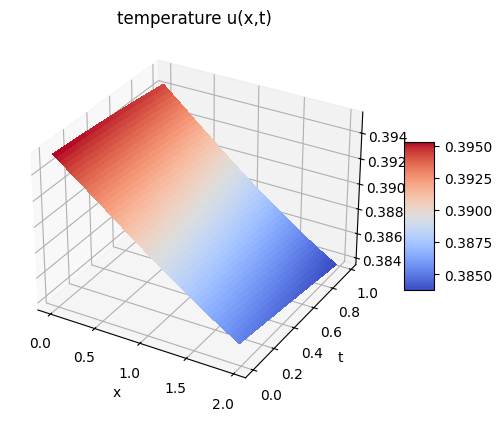

1 Traning Loss: tensor(2.4918, device='cuda:0')


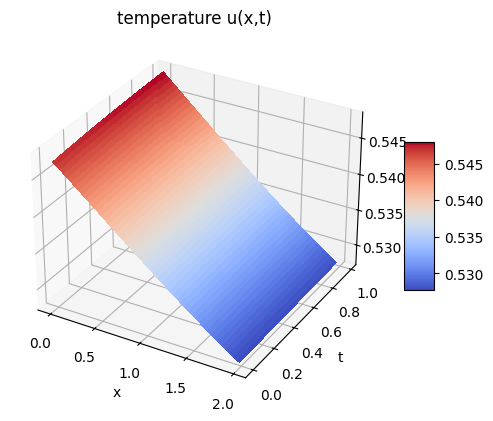

2 Traning Loss: tensor(2.4186, device='cuda:0')


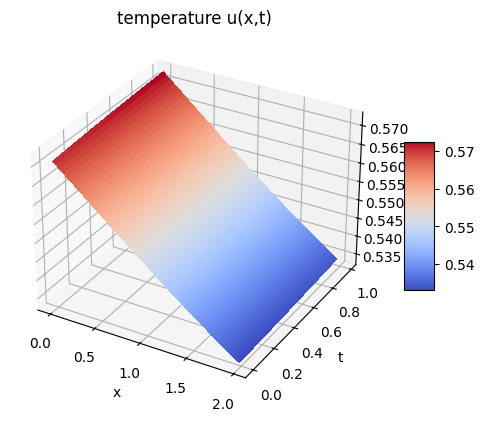

3 Traning Loss: tensor(2.5694, device='cuda:0')


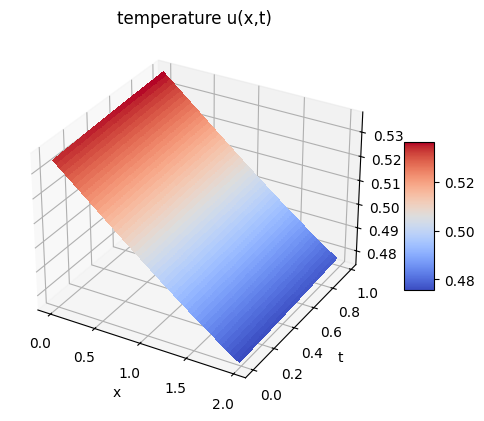

4 Traning Loss: tensor(2.3300, device='cuda:0')


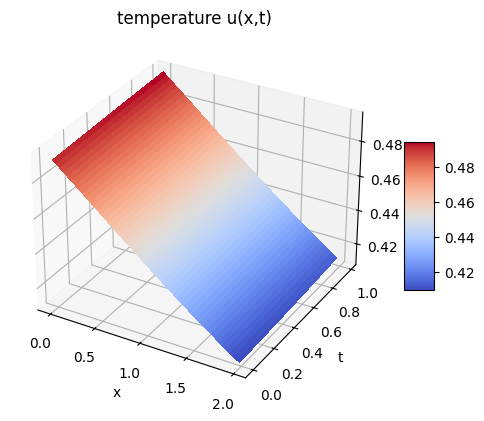

5 Traning Loss: tensor(2.1610, device='cuda:0')


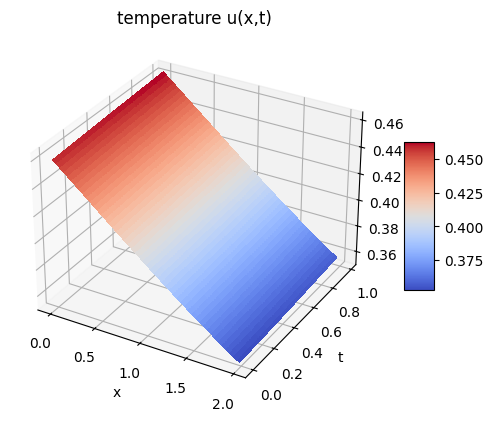

6 Traning Loss: tensor(1.9389, device='cuda:0')


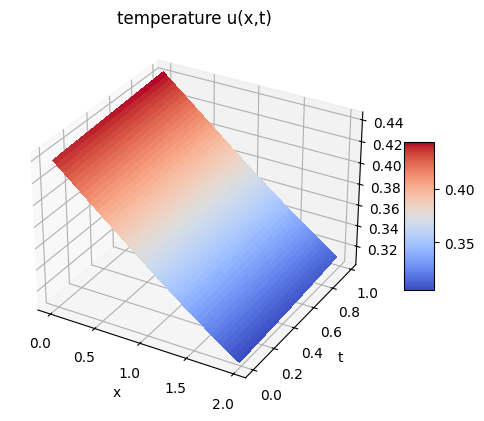

7 Traning Loss: tensor(1.8217, device='cuda:0')


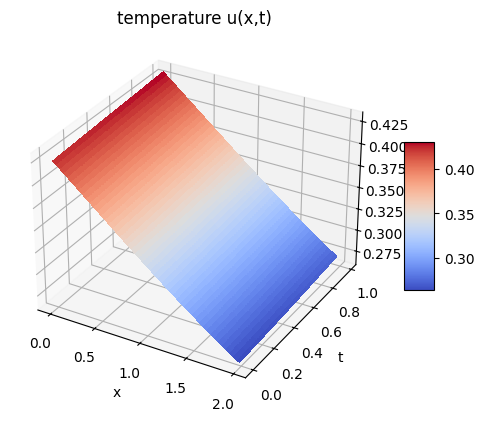

8 Traning Loss: tensor(1.4307, device='cuda:0')


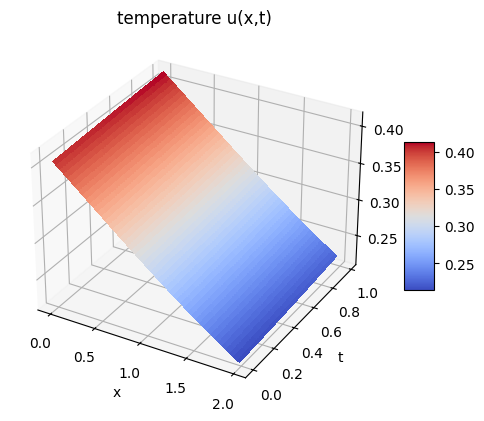

9 Traning Loss: tensor(1.5568, device='cuda:0')


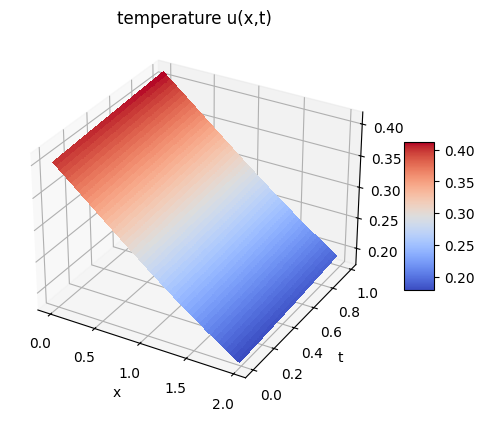

10 Traning Loss: tensor(1.4185, device='cuda:0')


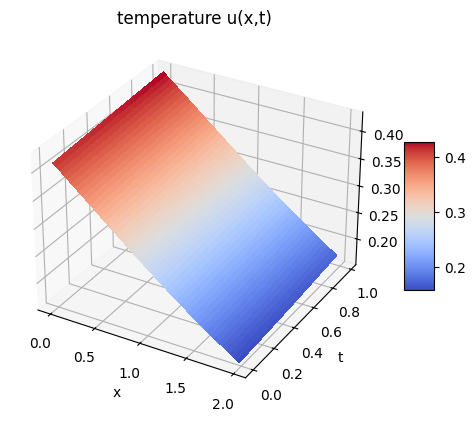

25 Traning Loss: tensor(0.4205, device='cuda:0')


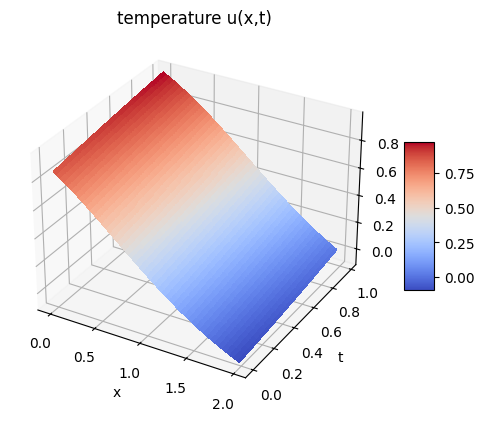

50 Traning Loss: tensor(0.1794, device='cuda:0')


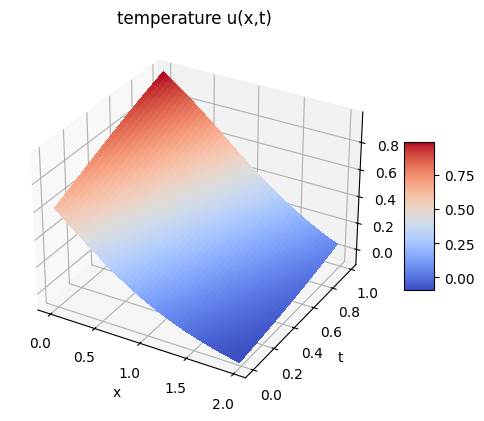

100 Traning Loss: tensor(0.1961, device='cuda:0')


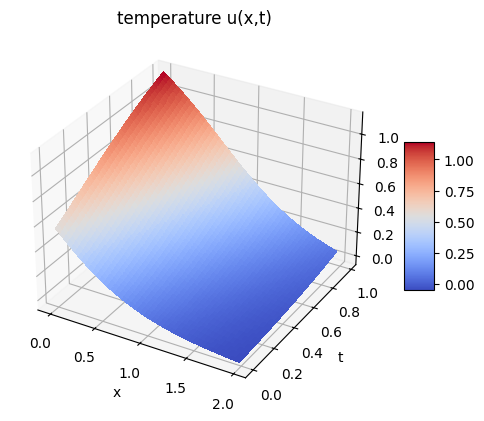

200 Traning Loss: tensor(0.1373, device='cuda:0')


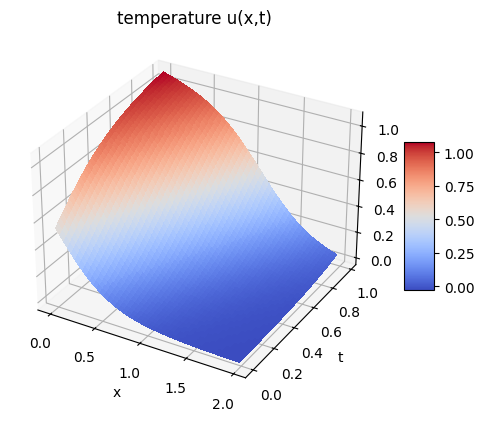

300 Traning Loss: tensor(0.0686, device='cuda:0')
400 Traning Loss: tensor(0.0907, device='cuda:0')
500 Traning Loss: tensor(0.0468, device='cuda:0')


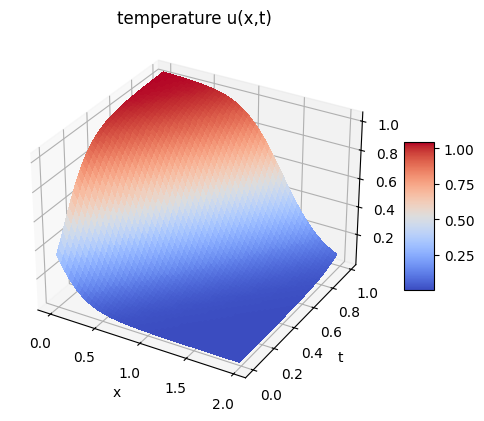

600 Traning Loss: tensor(0.0399, device='cuda:0')
700 Traning Loss: tensor(0.0535, device='cuda:0')
800 Traning Loss: tensor(0.0338, device='cuda:0')
900 Traning Loss: tensor(0.0255, device='cuda:0')
1000 Traning Loss: tensor(0.0186, device='cuda:0')


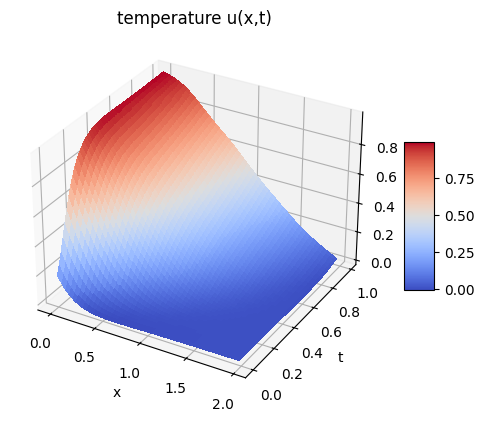

1100 Traning Loss: tensor(0.0070, device='cuda:0')
1200 Traning Loss: tensor(0.0035, device='cuda:0')
1300 Traning Loss: tensor(0.0069, device='cuda:0')
1400 Traning Loss: tensor(0.0041, device='cuda:0')
1500 Traning Loss: tensor(0.0019, device='cuda:0')


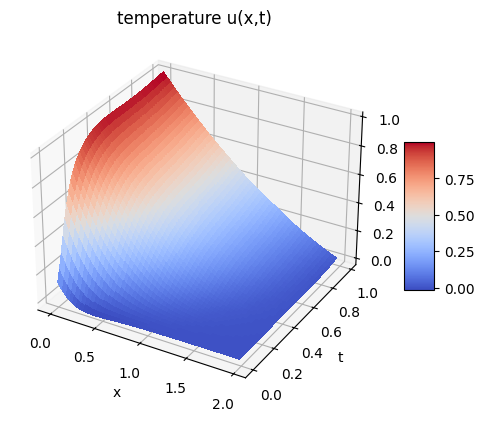

1600 Traning Loss: tensor(0.0026, device='cuda:0')
1700 Traning Loss: tensor(0.0029, device='cuda:0')
1800 Traning Loss: tensor(0.0015, device='cuda:0')
1900 Traning Loss: tensor(0.0019, device='cuda:0')
2000 Traning Loss: tensor(0.0016, device='cuda:0')


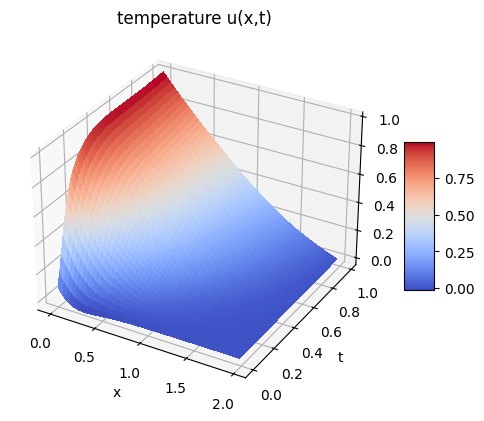

2100 Traning Loss: tensor(0.0008, device='cuda:0')
2200 Traning Loss: tensor(0.0012, device='cuda:0')
2300 Traning Loss: tensor(0.0040, device='cuda:0')
2400 Traning Loss: tensor(0.0019, device='cuda:0')
2500 Traning Loss: tensor(0.0014, device='cuda:0')


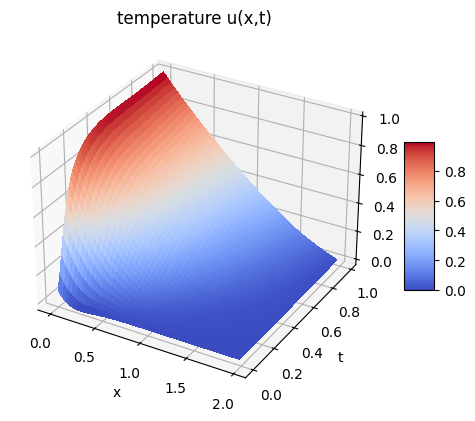

2600 Traning Loss: tensor(0.0014, device='cuda:0')
2700 Traning Loss: tensor(0.0009, device='cuda:0')
2800 Traning Loss: tensor(0.0015, device='cuda:0')
2900 Traning Loss: tensor(0.0012, device='cuda:0')
3000 Traning Loss: tensor(0.0012, device='cuda:0')


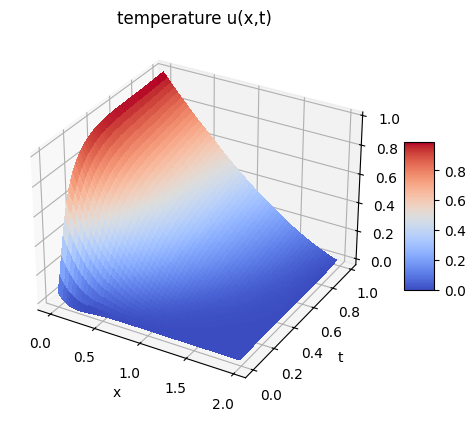

3100 Traning Loss: tensor(0.0011, device='cuda:0')
3200 Traning Loss: tensor(0.0010, device='cuda:0')
3300 Traning Loss: tensor(0.0009, device='cuda:0')
3400 Traning Loss: tensor(0.0008, device='cuda:0')
3500 Traning Loss: tensor(0.0005, device='cuda:0')


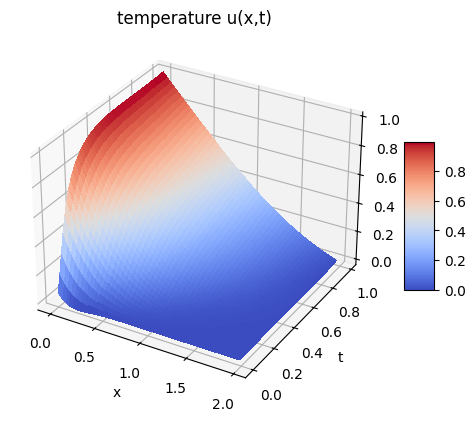

3600 Traning Loss: tensor(0.0023, device='cuda:0')
3700 Traning Loss: tensor(0.0018, device='cuda:0')
3800 Traning Loss: tensor(0.0011, device='cuda:0')
3900 Traning Loss: tensor(0.0008, device='cuda:0')
4000 Traning Loss: tensor(0.0013, device='cuda:0')


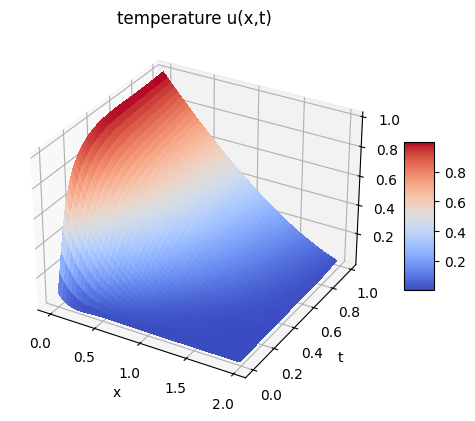

4100 Traning Loss: tensor(0.0008, device='cuda:0')
4200 Traning Loss: tensor(0.0007, device='cuda:0')
4300 Traning Loss: tensor(0.0006, device='cuda:0')
4400 Traning Loss: tensor(0.0011, device='cuda:0')
4500 Traning Loss: tensor(0.0016, device='cuda:0')


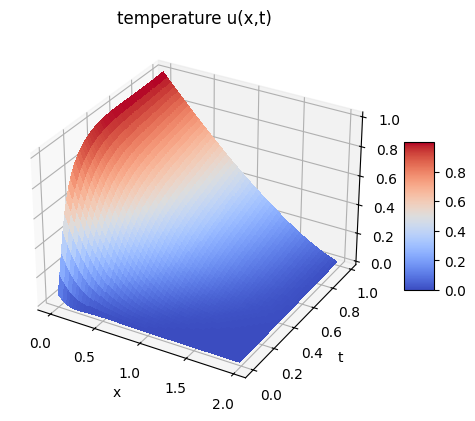

4600 Traning Loss: tensor(0.0006, device='cuda:0')
4700 Traning Loss: tensor(0.0027, device='cuda:0')
4800 Traning Loss: tensor(0.0021, device='cuda:0')
4900 Traning Loss: tensor(0.0013, device='cuda:0')


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

MM = meta_model(net)
MM.train(N_iter=5000) # increase as needed

# Interact with trained surrogate model

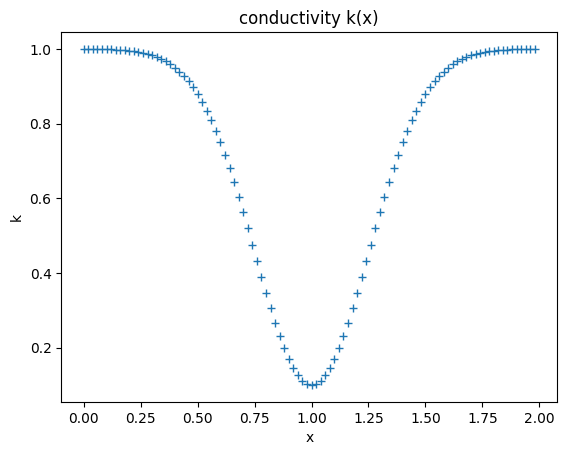

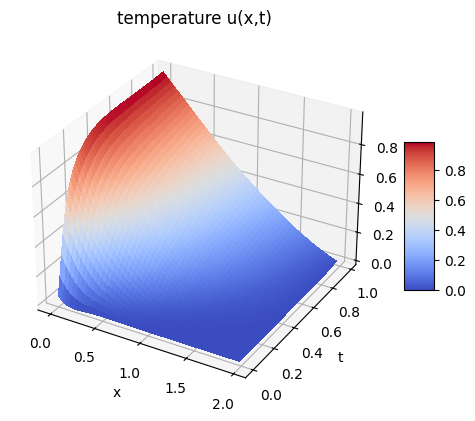

In [ ]:
conduct_param = 1. # to choose between 0 and 2

MM.plot(conduct_param,plot_conductivity=True,plot_contour=False)

solution [here](https://colab.research.google.com/drive/1hYYPtT-Ouj8nTA03si0n7HrAAtD4oA1Q?usp=sharing)